# Homework 2 Part 4: Attention-based classification

This last part of homework 2 will have you _using_ the vectors we learned from your word2vec implementation to do classification. You should complete the initial word2vec part before before starting on this.

Broadly, this last part of the homework consists of a few major steps:
1. Load in the data, word vectors, and word-indexing
2. Define the attention-based classification network
3. Train your model at least one epoch (2+ is recommended though).
4. Perform exploratory analyses on attention
5. Test the effects of freezing the pre-trained word vectors (see homework PDF for details)

After Step 2, you should be able to train your classifier implementation on a small percent of the dataset and verify that it's learning correctly. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**


### Estimated performance times

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading data, tokenizing, and converting to ids: ~20 seconds
* Training one epoch: ~18 minutes
* Training one epoch using frozen embeddings: ~3 minutes
* Evaluating on dev/test set: ~5 seconds

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim

import pandas as pd
import pickle
import math
import wandb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# Attention plotting
import matplotlib.pyplot as plt

# Load in the necessary parameters from the word2vec code

In [2]:
# Load the word-to-index mapping we used for word2vec and use the same type
# of tokenizer. We'll need to use this to tokenize in the same way and keep 
# the same word-to-id mapping

tokenizer = RegexpTokenizer(r'\w+')
# 假设你的映射和分词器保存在pickle文件中
word_to_index_file = './models/1st_model_word_to_index.pkl'
index_to_word_file = './models/1st_model_index_to_word.pkl'

# 加载word_to_index映射
with open(word_to_index_file, 'rb') as f:
    word_to_index = pickle.load(f)

# 加载index_to_word映射
with open(index_to_word_file, 'rb') as f:
    index_to_word = pickle.load(f)

# Define the Classifier Model

Just like we did for word2vec, let's define a PyTorch `nn.Module` class here that will contain our classifier.

In [3]:
class DocumentAttentionClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname, freeze_embeddings=False):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier, self).__init__()
        
        # Save the input arguments to the state
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
    
        # Create the Embedding object that will hold our word embeddings that we
        # learned in word2vec. This embedding object should have the same size
        # as what we learned before. However, we don't to start from scratch! 
        # Once created, load the saved (word2vec-based) parameters into the object
        # using load_state_dict.
        
        # Create the Embedding object
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        # Load pre-trained word embeddings
        self.embeddings.load_state_dict(torch.load(embeddings_fname))
        # 决定是否冻结词嵌入层
        if freeze_embeddings:
            for param in self.embeddings.parameters():  # 修改为正确的属性名
                param.requires_grad = False

                
        # Define the attention heads. You have two options:
        # 
        # 1) the worse way to implement this is to define your heads using an Embedding
        #    and then access them individually later in forward(). This will be slower
        #    but will probably still work 
        #
        # 2) the ideal way is to think of your attention heads as rows in a matrix--
        #    just like we do for word2vec. While this is kind of the same as how
        #    we represent things like in an Embedding, the key difference is that we
        #    can now use **matrix operations** to calculate the different r and a
        #    vectors, which will be much faster (and less code). To do this, you'll
        #    need to represent the attention heads as a Tensor directly (not a layer)
        #    and make sure pytorch runs gradient descent on these parameters.
        #
        #  It's up to you which to use, but try option 2 first and see what you do 
        #  in the forward() function
        
        self.attention_heads = nn.Parameter(torch.randn(num_heads, embedding_size))
        
        # Define the layer that goes from the concatenated attention heads' outputs
        # to the single output value. We'll push this output value through the sigmoid
        # to get our prediction

        self.linear = nn.Linear(num_heads * embedding_size, 1)  # Adjust the size accordingly
    

    def forward(self, word_ids):
        
        # Pro Tip™: when implementing this forward pass, try playing around with pytorch
        # tensors in a jupyter notebook by making "fake" versions of them. For example:
        #
        # word_embeds = torch.Tensor([[1,6,2], [9,1,7]])
        #
        # If you have two word embeddings of length 3, how can you define the attention
        # heads to get the 'r' vector? Trying things out in the simple case will let you
        # quickly verify the sequence of operations you want to run, e.g., that you can take
        # the softmax of the 'r' vector to get the 'a' vector and it has the right shape
        # and values
        
        # Hint 1: If you're representing attention using Option 2, most of this code is just 
        #         matrix multiplications

        # Hint 2: Most of your time is going to be spent figuring out shape errors and what
        #         operations you need to do to get the right outputs. This is normal.
        
        # Hint 3: This is the hardest part of this last part of the homework.

        
        # Get the word embeddings for the ids
        
        embeds = self.embeddings(word_ids)

        # Calcuate the 'r' vectors which are the dot product of each attention head
        # with each word embedding. You should be getting a tensor that has this
        # dot product back out---remember this vector is capturing how much the 
        # head thinks the vector is relevant for the task
        
        relevance_scores = torch.matmul(embeds, self.attention_heads.t())  # [batch_size, seq_length, num_heads]

        # Calcuate the softmax of the 'r' vector, which call 'a'. This will give us
        # a probability distribution over the tokens for each head. Be sure to check
        # that the softmax is being calculated over the right axis/dimension of the 
        # data (You should see probability values that sum to 1 for each head's 
        # ratings across all the tokens)   
        
        attention_weights = F.softmax(relevance_scores, dim=1)  # [batch_size, seq_length, num_heads]

        # Calculate the re-weighting of the word embeddings for each head's attention
        # weight and sum the reweighted sequence for each head into a single vector.
        # This should give you n_heads vectors that each have embedding_size length.
        # Note again that each head should give you a different weighting of the
        # input word embeddings
        weighted_embeds = torch.einsum('bsn,bse->bne', attention_weights, embeds)  # [batch_size, num_heads, embedding_size]

        
        # Create a single vector that has all n_heads' attention-weighted vectors
        # as one single vector. We need this one-long-vector shape so that we 
        # can pass all these vectors as input into a layer.
        #
        # NOTE: if you're doing Option 2 for representing attention, you don't 
        # actually need to create a new vector (which is very inefficient).
        # Instead, you can create a new *view* of the same data that reshapes the
        # different heads' vectors so it looks like one long vector. 
        
        concatenated = weighted_embeds.view(weighted_embeds.size(0), -1)  # [batch_size, num_heads * embedding_size]


        # Pass the side-by-side attention-weighted vectors through your linear
        # layer to get some output activation.
        #
        # NOTE: if you're feeling adventurous, try adding an extra layer here
        # which will allow you different attention-weighted vectors to interact
        # in making the model decision
        
        output0 = self.linear(concatenated)  # [batch_size, 1]
        
        # Return the sigmoid of the output activation *and* the attention 
        # weights for each head. We'll need these later for visualization
        probability1 = torch.sigmoid(output0).squeeze(-1)  # 仅移除最后一个维度，如果它是单一的
        return probability1, attention_weights

# Load in the datasets 

You can keep these as pandas data frames.

In [4]:
# 假设你的数据存储在CSV文件中
train_data_path = 'sentiment.train.csv'
dev_data_path = 'sentiment.dev.csv'
test_data_path = 'sentiment.test.csv'

# 使用pandas读取数据
sent_train_df = pd.read_csv(train_data_path)
sent_dev_df = pd.read_csv(dev_data_path)
sent_test_df = pd.read_csv(test_data_path)

Convert each dataset into a list of tuples of the form `([word-ids,...], label)`. Both the word ids and the label should be numpy arrays so they will get converted into Tensors by our data loader. Note that you did something very similar for creating the word2vec training data. This process will require tokenizing the data in the same way as you did for word2vec and using the same word-to-id mapping (both of which you loaded/created above).

In [5]:
def tokenize_and_convert_to_ids(text, tokenizer, word_to_index):
    tokens = tokenizer.tokenize(text)
    ids = [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens]
    return np.array(ids)

def prepare_data(df, tokenizer, word_to_index):
    data_list = []
    for index, row in df.iterrows():
        word_ids = tokenize_and_convert_to_ids(row['text'], tokenizer, word_to_index)
        label = np.array(row['label'])
        data_list.append((word_ids, label))
    return data_list

def prepare_test_data(df, tokenizer, word_to_index):
    test_data = []
    for text in df['text']:
        word_ids = tokenize_and_convert_to_ids(text, tokenizer, word_to_index)
        test_data.append(torch.tensor(word_ids, dtype=torch.long))
    return test_data

# 使用定义的函数准备测试数据
test_data = prepare_test_data(sent_test_df, tokenizer, word_to_index)

# 现在，假设你的数据帧已经正确加载
# 以下是如何应用上述函数的例子
train_list = prepare_data(sent_train_df, tokenizer, word_to_index)
dev_list = prepare_data(sent_dev_df, tokenizer, word_to_index)
test_list = prepare_test_data(sent_test_df, tokenizer, word_to_index)

If this worked you should see XXXX train, XXXX dev, and XXX test instances.

In [6]:
len(train_list), len(dev_list), len(test_list)

(160000, 20000, 20000)

# Build the code training loop

We'll evaluate periodically so before we start training, let's define a function that takes in some evaluation data (e.g., the dev or test sets) and computes the F1 score on that data. 

In [7]:
def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    model.eval()  # 切换到评估模式
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for word_ids, labels in eval_data:
            probability, _ = model(word_ids)  # 提取概率输出，忽略注意力权重
            preds = torch.round(probability)  # 将输出转换为0或1的预测
            
            # 确保preds和labels是可迭代的
            preds_list = [preds.item()] if preds.dim() == 0 else preds.tolist()
            labels_list = [labels.item()] if labels.dim() == 0 else labels.tolist()

            all_preds.extend(preds_list)
            all_labels.extend(labels_list)
            
    f1 = f1_score(all_labels, all_preds)
    model.train()  # 切换回训练模式
    return f1

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The training code will look surprisingly similar to your word2vec code. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. **see below:** Initializes Weights & Biases and periodically write our running-sum of the loss 
5. Train your model 

For step 4, in addition to writing the loss, you should write the F1 score on the dev set to the `wandb` as well, using the specified number of steps.

**NOTE:** In this training, you'll use a batch size of 1, which will make your life _much_ simpler.

In [8]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word_ids, label = self.data[idx]
        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# TODO: Set your training stuff, hyperparameters, models, etc. here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_index)  # 假设word_to_index是你的词汇到索引的映射
embedding_size = 50  # 或你在word2vec中使用的任何尺寸
num_heads = 4  # 注意力头的数量
batch_size = 1
learning_rate = 0.001
epochs = 1  # 或更多，根据需要
max_steps = 1000000000  # 设置最大步数
patience = 30000 # 设置耐心值，即在这么多步之后如果没有提升则停止训练
best_f1 = 0.0  # 记录迄今为止最好的F1分数
steps_since_improvement = 0  # 记录自上次性能提升以来的步数
# 初始化收集损失和F1分数的列表
losses = []
f1_scores = []

embeddings_file_path = './models/1st_model_embeddings_state_dict.pt'
model = DocumentAttentionClassifier(vocab_size=vocab_size, embedding_size=embedding_size, num_heads=num_heads, embeddings_fname=embeddings_file_path)
loss_function = torch.nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# TODO: initialize weights and biases (wandb) here
wandb.init(project="attention_classifier", entity="yanzhuo")
# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

# 创建DataLoader实例
train_dataset = TextDataset(train_list)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dev_dataset = TextDataset(dev_list)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: yanzhuo. Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/160000 [00:00<?, ?it/s]

Step 500, Avg Loss: 0.6647664252519607
Step 1000, Avg Loss: 0.5674404768794775
Step 1500, Avg Loss: 0.5355042623952031
Step 2000, Avg Loss: 0.4714980525150895
Step 2500, Avg Loss: 0.4787217322997749
Step 3000, Avg Loss: 0.44343255343101917
Step 3500, Avg Loss: 0.43280329973530024
Step 4000, Avg Loss: 0.37574428563565015
Step 4500, Avg Loss: 0.4118676066175103
Step 5000, Avg Loss: 0.3628025410901755
-----Step 5000, F1 Score: 0.8034399355012094-----
Step 5500, Avg Loss: 0.37146949844644406
Step 6000, Avg Loss: 0.35629325722763316
Step 6500, Avg Loss: 0.4159240174258593
Step 7000, Avg Loss: 0.40242673734994605
Step 7500, Avg Loss: 0.3839249237542972
Step 8000, Avg Loss: 0.36940104012587105
Step 8500, Avg Loss: 0.3671781004606746
Step 9000, Avg Loss: 0.3696607590555213
Step 9500, Avg Loss: 0.41489909155503846
Step 10000, Avg Loss: 0.3680297930869274
-----Step 10000, F1 Score: 0.8394834840644194-----
Step 10500, Avg Loss: 0.36267806810000913
Step 11000, Avg Loss: 0.41367440670612265
Step 11

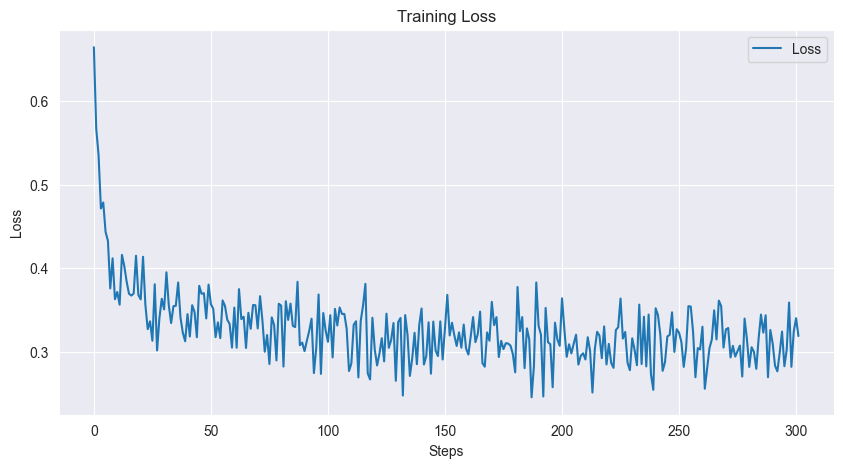

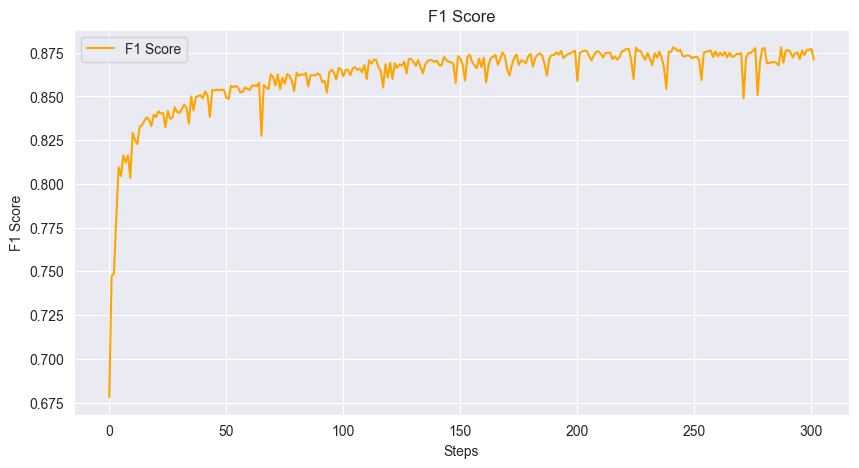

DocumentAttentionClassifier(
  (embeddings): Embedding(40547, 50)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [9]:
# 以下是修正后的训练循环
for epoch in tqdm(range(epochs), desc="Epoch"):
    model.train()
    running_loss = 0.0

    for step, (word_ids, labels) in enumerate(tqdm(train_loader, desc="Training")):
        word_ids, labels = word_ids.to(device), labels.to(device)

        optimizer.zero_grad()
        probability, _ = model.forward(word_ids)
        loss = loss_function(probability, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step + 1) % 500 == 0:
            avg_loss = running_loss / 500
            dev_f1 = run_eval(model, dev_loader)
            print(f"Step {step + 1}, Avg Loss: {avg_loss}")
            wandb.log({"loss": avg_loss, "f1_score": dev_f1})
            if (step + 1) % 5000 == 0:
                print(f"-----Step {step + 1}, F1 Score: {dev_f1}-----")
            losses.append(avg_loss)
            f1_scores.append(dev_f1)
            running_loss = 0.0

            if dev_f1 > best_f1:
                best_f1 = dev_f1
                steps_since_improvement = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                steps_since_improvement += 500
                if steps_since_improvement >= patience:
                    print("Early stopping triggered due to no improvement.")
                    break

        if step >= max_steps or steps_since_improvement >= patience:
            print("Early stopping triggered.")
            break

# 绘制损失
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制F1分数
plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.title('F1 Score')
plt.xlabel('Steps')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 训练结束后加载最佳模型
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # 切换到评估模式

In [10]:
predictions = []
with torch.no_grad():
    for word_ids in test_data:
        # 由于我们的模型是基于批处理的，我们需要添加一个批次维度
        probability, _ = model.forward(word_ids.unsqueeze(0))  # 假设模型返回预测和注意力权重
        prediction = torch.round(probability[0]).item()  # 将输出转换为类别标签
        predictions.append(prediction)

# 将预测结果添加到DataFrame中
sent_test_df['predicted_label'] = predictions

test_output=pd.DataFrame({'inst_id':sent_test_df['inst_id'],'predicted_label':sent_test_df['predicted_label']})
# 保存到CSV文件中
test_output.to_csv('test_predictions.csv', index=False)

# 打印前几个预测结果作为验证
print(sent_test_df.head())

   inst_id                                               text  predicted_label
0        0  Really sad review as I absolutely loved the fi...              0.0
1        1  Excellent content, perfect for Christians who ...              1.0
2        2  This is an okay book if you need advice on bud...              1.0
3        3  This is one book you can't put down! This book...              1.0
4        4  There were to many names that I had no idenity...              0.0
